# <center> Exploring the Factors that Drive Coffee Ratings
## <center> Journal of Emerging Investigators 
### <center> Anya Agarwal, Nicolas Cutrona, Dominique Guillot

This notebook coincides with work submitted to the Journal of Emerging Investigagors. Our project makes use of publicly available data from the Coffee Quality Institute to build a linear regression model to understand which attributes contribute most to expert ratings on coffee quality. We first present exploratory data analysis.

## I. Exploratory Data Analysis

In this section, we will visualize different aspects the coffee quality index data. We will explore the distribution of the continuous and discrete attributes, as well as the linearity of the predictor attributes with respect to the target attribute, namely "total_cup_points". 

In [41]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [56]:
#importing the data
data = pd.read_csv('/Users/nicolascutrona/Desktop/coffee_data.csv')
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,total_cup_points,species,owner,country_of_origin,region,producer,number_of_bags,aroma,flavor,aftertaste,acidity,sweetness,cupper_points,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,90.58,Arabica,metad plc,Ethiopia,guji-hambela,METAD PLC,300,8.67,8.83,8.67,8.75,10.00,8.75,1950.0,2200.0,2075.0
1,89.92,Arabica,metad plc,Ethiopia,guji-hambela,METAD PLC,300,8.75,8.67,8.50,8.58,10.00,8.58,1950.0,2200.0,2075.0
2,89.00,Arabica,yidnekachew dabessa,Ethiopia,oromia,Yidnekachew Dabessa Coffee Plantation,320,8.17,8.58,8.42,8.42,10.00,8.67,1800.0,2200.0,2000.0
3,88.83,Arabica,metad plc,Ethiopia,guji-hambela,METAD PLC,300,8.25,8.50,8.25,8.50,10.00,8.58,1950.0,2200.0,2075.0
4,88.67,Arabica,ethiopia commodity exchange,Ethiopia,oromia,Bazen Agricultural & Industrial Dev't Plc,300,8.25,8.33,8.50,8.42,9.33,9.00,1570.0,1700.0,1635.0


In [58]:
#data shape
print("Number of Variables:", data.shape[1], "Number of Samples:", data.shape[0])

Number of Variables: 16 Number of Samples: 997


**Distribution of Categoraical Variables**

In [4]:
def cat_dist(dataframe, length, width, cat_attribute_list):
    figure, axis = plt.subplots(1, len(cat_attribute_list), figsize=(length, width))
    for i in range(len(cat_attribute_list)):
        axis[i].hist(dataframe[cat_attribute_list[i]])
        axis[i].set_title(cat_attribute_list[i])
        axis[i].set_xlabel(cat_attribute_list[i])
        axis[i].set_ylabel("frequency")
        if(cat_attribute_list[i] != "species"):
            axis[i].get_xaxis().set_visible(False)
            axis[i].get_yaxis().set_visible(False)
    figure.suptitle("Distribution of Categorical Predictors")
    plt.subplots_adjust(top=0.85)
    # figure.tight_layout()
    plt.show()   

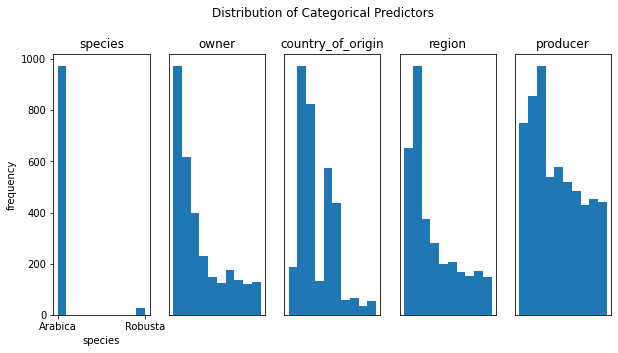

In [5]:
categorical_attributes = ["species", "owner", "country_of_origin", "region", "producer"]
cat_dist(data, 10, 5, categorical_attributes)

In [6]:
#vislualzing top five highest frequent owners, countries of origin, regions, and producers
value_counts_owner = data['owner'].value_counts().nlargest(5).reset_index()
value_counts_country_of_origin = data['country_of_origin'].value_counts().nlargest(5).reset_index()
value_counts_region = data['region'].value_counts().nlargest(5).reset_index()
value_counts_producer = data['producer'].value_counts().nlargest(5).reset_index()

#rename the columns for clarity
value_counts_owner.columns = ['owner', 'count']
value_counts_country_of_origin.columns = ['country_of_origin', 'count']
value_counts_region.columns = ['region', 'count']
value_counts_producer.columns = ['producer', 'count']


combined_counts = pd.concat([value_counts_owner, value_counts_country_of_origin, value_counts_region, value_counts_producer], axis=1)
combined_counts.columns = ['owner', 'count', 'country_of_origin', 'count', 'region', 'count', 'producer', 'count']

combined_counts.head()


,owner,count,country_of_origin,count,region,count,producer,count
0,juan luis alvarado romero,133,Mexico,230,south of minas,66,Ipanema Agrícola SA,22
1,ipanema coffees,50,Guatemala,151,oriente,65,La Plata,20
2,cqi taiwan icp cqi台灣合作夥伴,42,Brazil,103,huila,54,Ipanema Agricola,12
3,racafe & cia s.c.a,32,Colombia,79,veracruz,31,VARIOS,12
4,"lin, che-hao krude 林哲豪",29,Taiwan,69,tarrazu,18,Ipanema Agricola S.A,11


**Analysis**  (Note: the x-axis labels are removed due to spatial limitations of the plots)




**species**: We see that the vast majority of the beans are of the Arabica species. Clearly we do not have a uniform distribution in this case. Only a small number of coffee producers use the Robusta species of bean.




**owner**: We can see that Juan Luis Alvarado Romero and Ipanema Coffees own the majority of the beans. We have a scewed distribution because these are the top five bean owners.




**country_of_origin**: We can see that the majority of the beans come from Mexico, Guatemala, and Brazil. Because these are the top five countries of origin for the beans, we have a decreasing distribution.




**region**: We can see that the majority of the beans come from South of Minas and Oriente. Because these are the top five regions for the beans, we have a scewed distribution.




**producer**: We can see that the majority of the beans are produced by Ipanema Agrícola SA and La Plata. Because these are the top five bean producers, we have a scewed distribution.






**Distribution of Continuous Attributes**

In [7]:
def cont_dist(dataframe, length, width, cont_attribute_list):
    figure,axis = plt.subplots(3,4,figsize=(length, width))
    for i in range(len(cont_attribute_list)):
        att_list = list(dataframe[cont_attribute_list[i]])
        mu, std = norm.fit(att_list) 
        if(i < 4):
            axis[0, i].hist(dataframe[cont_attribute_list[i]], bins=10, density=True, alpha=0.6, color='b')   
            xmin, xmax = axis[0, i].get_xlim() 
            x = np.linspace(xmin, xmax, 100) 
            p = norm.pdf(x, mu, std) 
            axis[0, i].plot(x, p, 'k', linewidth=2)
            axis[0, i].set_title(cont_attribute_list[i]) 
            axis[0, i].set_xlabel(cont_attribute_list[i]) 
            axis[0, i].set_ylabel("frequency") 
        elif(4 <= i < 8):
            axis[1, i%4].hist(dataframe[cont_attribute_list[i]], bins=10, density=True, alpha=0.6, color='b')   
            xmin, xmax = axis[1, i%4].get_xlim() 
            x = np.linspace(xmin, xmax, 100) 
            p = norm.pdf(x, mu, std) 
            axis[1, i%4].plot(x, p, 'k', linewidth=2)
            axis[1, i%4].set_title(cont_attribute_list[i]) 
            axis[1, i%4].set_xlabel(cont_attribute_list[i]) 
            axis[1, i%4].set_ylabel("frequency")
        else:
            axis[2, i%4].hist(dataframe[cont_attribute_list[i]], bins=10, density=True, alpha=0.6, color='b')   
            xmin, xmax = axis[0, i%4].get_xlim() 
            x = np.linspace(xmin, xmax, 100) 
            p = norm.pdf(x, mu, std) 
            axis[2, i%4].plot(x, p, 'k', linewidth=2)
            axis[2, i%4].set_title(cont_attribute_list[i]) 
            axis[2, i%4].set_xlabel(cont_attribute_list[i]) 
            axis[2, i%4].set_ylabel("frequency")
            
            
    figure.suptitle('Distribution of the Conintuous Predictors')
    figure.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()   

In [8]:
continuous_attributes = ['number_of_bags', 'aroma', 'flavor',
       'aftertaste', 'acidity', 'sweetness', 'cupper_points',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']

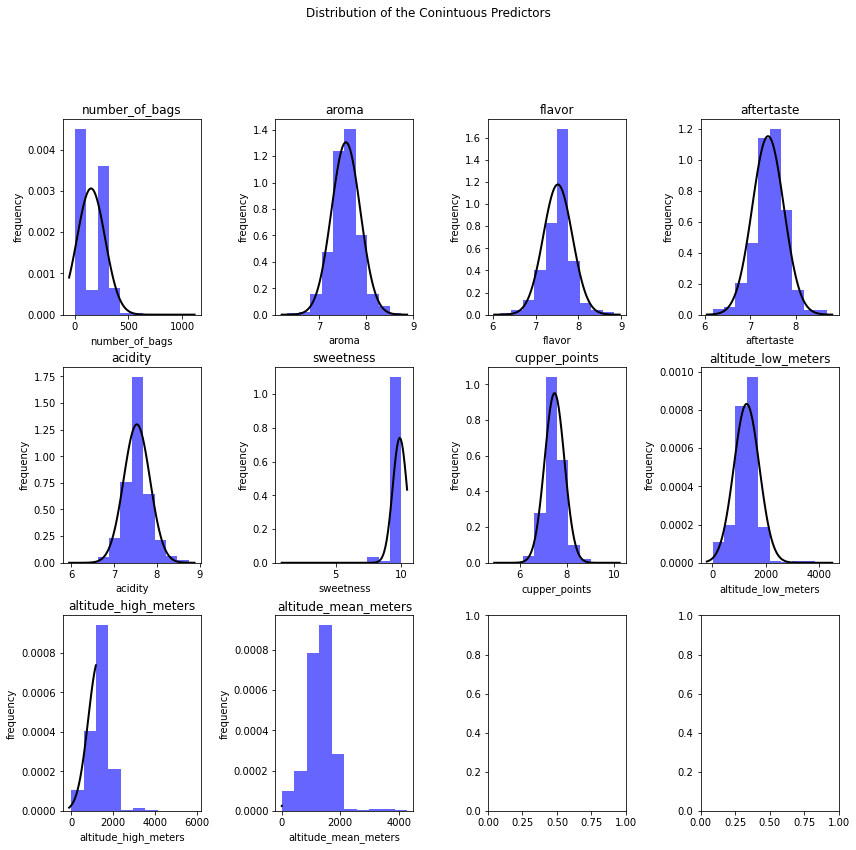

In [9]:
cont_dist(data,12,12,continuous_attributes)

**number of bags**: We see that the number_of_bags predictor does not follow a normal distribution. There is a clear right skew to the data.




**aroma**: The aroma predictor appears to be approximately normal. 




**flavor**: The flavor predictor is also approximately normal; however, there appears to be a large spike in flavor scores between 7 and 8.




**aftertaste**: The aftertaste predictor appears to be approximately normal. 




**acidity**: The acidity predictor is also approximately normal; however, there appears to be a large spike in flavor scores between 7 and 8.




**sweetness**: We see that the sweetness predictor does not follow a normal distribution. There is a clear left skew to the data.


**cupper_points**: We see that the cupper_points predictor appears to be approximately normal.


**altitude_low_meters**: We see that the altitude_low_meters predictor appears to be approximately normal, but there is a slight right skew to the data.




**altitude_high_meters**: We see that the altitude_low_meters predictor appears to be approximately normal, but there is a slight right skew to the data.




**altitude_mean_meters**: We see that the altitude_low_meters predictor appears to be approximately normal, but there is a slight right skew to the data.






**Linearity of the predictor attribute v.s. the target attribute**

In [10]:
def linearity_plot(dataframe, target, length, width, cont_attribute_list):
    target = dataframe[target]
    figure, axis = plt.subplots(3, 4, figsize = (length, width))
    for i in range(len(cont_attribute_list)):
            if(i < 4):
                axis[0, i].scatter(dataframe[cont_attribute_list[i]], target, s = 5) 
                axis[0, i].set_title(cont_attribute_list[i]) 
                axis[0, i].set_xlabel(cont_attribute_list[i]) 
                axis[0, i].set_ylabel("points")
            elif(4 <= i < 8):
                axis[1, i%4].scatter(dataframe[cont_attribute_list[i]], target, s = 5) 
                axis[1, i%4].set_title(cont_attribute_list[i]) 
                axis[1, i%4].set_xlabel(cont_attribute_list[i]) 
                axis[1, i%4].set_ylabel("points")
            else:
                axis[2, i%4].scatter(dataframe[cont_attribute_list[i]], target, s =5) 
                axis[2, i%4].set_title(cont_attribute_list[i]) 
                axis[2, i%4].set_xlabel(cont_attribute_list[i]) 
                axis[2, i%4].set_ylabel("points")
                
                
    suptitle = figure.suptitle('Attribute vs. Target Linearity')
    suptitle.set_position([0.5, 1.05]) 
    figure.tight_layout()
    plt.show()

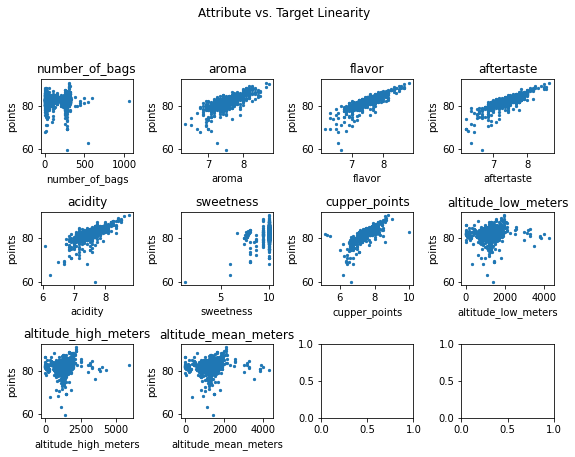

In [11]:
linearity_plot(data, "total_cup_points", 8,6,continuous_attributes)

In [12]:
#correlation coefficients
coef = []
for i in range(len(continuous_attributes)):
    coef.append(np.corrcoef(data['total_cup_points'], data[continuous_attributes[i]])[0][1])
correlation_data = pd.DataFrame(columns = ["attribute", "correlation coefficient"])
correlation_data["attribute"] = continuous_attributes
correlation_data["correlation coefficient"] = coef
correlation_data

,attribute,correlation coefficient
0,number_of_bags,0.039961
1,aroma,0.710721
2,flavor,0.835127
3,aftertaste,0.827015
4,acidity,0.723699
5,sweetness,0.380626
6,cupper_points,0.771323
7,altitude_low_meters,0.126459
8,altitude_high_meters,0.143948
9,altitude_mean_meters,0.137820


**number of Bags**: We see that the number_of_bags predictor has a weak positive linear relationship with total_cup_points




**aroma**: The aroma predictor is clearly strongly positive linear relationship with total_cup points. We will expect the model to predict higher total_cup_points as the aroma measure increases.




**flavor**: There is a clear positive linear relationship between flavor and total_cup_points. We expect the model to predict higher total_cup_points for higher flavor values.




**aftertaste**: The aftertaste predictor is clearly strongly positive linear relationship with total_cup points. We will expect the model to predict higher total_cup_points as the aftertaste measure increases.




**acidity**: There is a mild positive linear relationship between acidity and total_cup_points. We expect the model to predict slightly higher total_cup_points for higher acidity values.




**sweetness**: The relationship between sweetness and total_cup_points is a weak positive linear relationship. There is some scatter, and the trend line is relatively flat. We should be cautious about interpreting the model's predictions for this attribute.


**cupper_points**: We see that cupper_points has a clear positive linear relationship with total_cup_points. We also expect the model to predict higher total_cup_points as the cupper_points increase.


**altitude_low_meters**: Then altitude_low_meters predictor has a weak positive linear relationship with total_cup_points. We can expect that the model will slightly reduce its prediction of total_cup_points for coffees grown at lower altitudes.




**altitude_high_meters**: We see that the altitude_high_meters predictor does not have a necessarily strong linear relationship with total_cup_points. It has a weak positive linear relationship with total_cup_points, which means we can expect that the model will slightly increase its prediction of total_cup_points for coffees grown at higher altitudes.




**Altitude_mean_meters**: Then altitude_mean_meters predictor has a weak positive linear relationship with total_cup_points. We can expect that the model will slightly increase its prediction of total_cup_points for coffees grown at lower mean altitudes.






**Creating Dummy Variables**

Given a categorical variable with $n$ different categories, we know that we will have $n-1$ dummy variables to represent this predictor. 

Category Information:

species Number of Categories: 2
owner Number of Categories: 277
country_of_origin Number of Categories: 35
region Number of Categories: 321
producer Number of Categories: 632


Text(0, 0.5, 'Number of Categories')

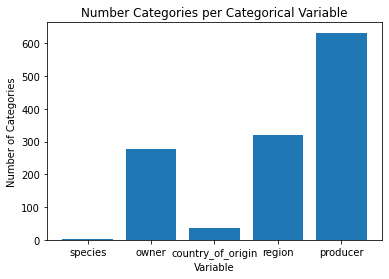

In [13]:
#Visualizing the number of categories we have for each categorical variable
print("Category Information:\n")
num_cat = []
cat_variables = ['species', 'owner', 'country_of_origin', 'region', 'producer']
for i in range(len(cat_variables)):
    print(cat_variables[i] + " Number of Categories:", len(np.unique(data[cat_variables[i]])))
    num_cat.append(len(np.unique(data[cat_variables[i]])))
    
plt.bar(cat_variables, num_cat)
plt.title("Number Categories per Categorical Variable")
plt.xlabel("Variable")
plt.ylabel("Number of Categories")

We see that there would be far too many dummy variables to include in our regression model. We must ensure that the number of attributes fed into the model is less than the number of samples in the data. To handle this, we will define new categorical variables for owner, country_of_origin, region, and producer as follows:

Let $x_i$ be $i^{th}$ categorical variable. Let $\{a, b, c, d, e\}$ denote the five most common values of $x_i$. Then we define

$z_{i,a} = 1$ if $x_i = a$ and $0$ otherwise.
$z_{i,b} = 1$ if $x_i = b$ and $0$ otherwise.
$z_{i,c} = 1$ if $x_i = c$ and $0$ otherwise.
$z_{i,d} = 1$ if $x_i = d$ and $0$ otherwise.
$z_{i,e} = 1$ if $x_i = e$ and $0$ otherwise.

If the value of $x_i$ is none of $\{a, b, c, d, e\}$, then $z_{i,a}  = z_{i,b} = z_{i,c} = z_{i,d} = z_{i,e}  = 0$.

In [14]:
#creating dummy variables
def make_dummies(dataframe, categorical_variable):
    top_five = list(dataframe[categorical_variable].value_counts()[:5].keys())
    for i in range(len(top_five)):
        values = list(dataframe[categorical_variable])
        for j in range(len(values)):
            if(values[j] == top_five[i]):
                values[j] = 1
            else:
                values[j] = 0
        dataframe[categorical_variable + "_" + top_five[i]] = values
    dataframe = dataframe.drop(categorical_variable, axis=1)
    return dataframe

In [15]:
#updating the data with dummy variables
data = make_dummies(data, 'country_of_origin')
data = make_dummies(data, 'owner')
data = make_dummies(data, 'region')
data = make_dummies(data, 'producer')
data.loc[data['species'] == 'Arabica', 'species'] = 1
data.loc[data['species'] == 'Robusta', 'species'] = 0
data.head()

,total_cup_points,species,number_of_bags,aroma,flavor,aftertaste,acidity,sweetness,cupper_points,altitude_low_meters,...,region_south of minas,region_oriente,region_huila,region_veracruz,region_tarrazu,producer_Ipanema Agrícola SA,producer_La Plata,producer_Ipanema Agricola,producer_VARIOS,producer_Ipanema Agricola S.A
0,90.58,1,300,8.67,8.83,8.67,8.75,10.00,8.75,1950.0,...,0,0,0,0,0,0,0,0,0,0
1,89.92,1,300,8.75,8.67,8.50,8.58,10.00,8.58,1950.0,...,0,0,0,0,0,0,0,0,0,0
2,89.00,1,320,8.17,8.58,8.42,8.42,10.00,8.67,1800.0,...,0,0,0,0,0,0,0,0,0,0
3,88.83,1,300,8.25,8.50,8.25,8.50,10.00,8.58,1950.0,...,0,0,0,0,0,0,0,0,0,0
4,88.67,1,300,8.25,8.33,8.50,8.42,9.33,9.00,1570.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#updated data shape
print("Number of Variables:", data.shape[1], "Number of Samples:", data.shape[0])

Number of Variables: 32 Number of Samples: 997


Now that our data has been processed to all numerical values, we construct a correlation heatmap to determine if there is multi-colinearity in the data. 

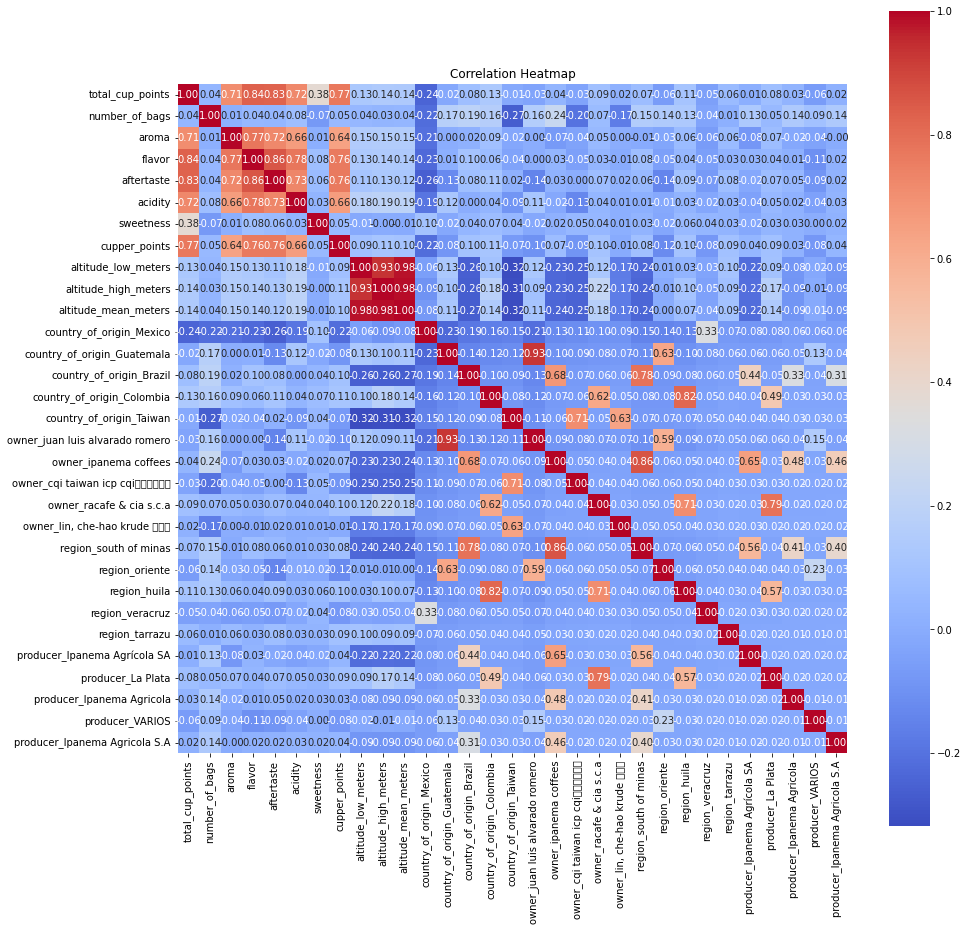

In [17]:
# Step 2: Compute the correlation matrix
correlation_matrix = data.corr()

# Step 3: Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)

# Add titles and labels
plt.title('Correlation Heatmap')
plt.show()

We see that there is some multi-colinearity present. Namely, there is strong multicolinearity between the altitude variables and moderate to high multicolinearity between the taste variabes (aroma, aftertaste, flavor, and acidity). In particular, aftertaste and flavor are highly correlated. Therefore, we will remove the aftertaste, altitude_low, and altitude high attributes from the design matrix for analysis. We also see some of the dummy variables are correlated. In particular, the region_hulia variable is highly correlated with the country_of_origin_columbia and the owner_racafe & cia s.c.a. variables. So we will remove region_hulia from the data. We also remove the region_south of minas from the data, as it is highly correlated with the country_of_origin_Brazil variable and the owner_ipanema coffees variable. We see that owner_juan luis alvarado romero variable is highly correlated with country_of_origin_Guatamala variable. Thus we remove owner_juan luis alvardo romero from the data. Lastly we remove the producer_La plata variables as it is highly correlated with the owner_racafe &cia s.c.a. variable.

## II. Model Building

In this section, we pre-process our data and build a linear regression model via gradient descent optimization.

In [18]:
#generating design matrix and target vector
data = data.drop("aftertaste", axis = 1)
data = data.drop("altitude_low_meters", axis = 1)
data = data.drop("altitude_high_meters", axis = 1)
data = data.drop("region_huila", axis = 1)
data = data.drop("region_south of minas", axis = 1)
data = data.drop("owner_juan luis alvarado romero", axis = 1)
data = data.drop("producer_La Plata", axis = 1)
features = list(data.columns)
features.remove("total_cup_points")
y_coffee = data['total_cup_points']
X_coffee = data[features]
X_coffee.head()

,species,number_of_bags,aroma,flavor,acidity,sweetness,cupper_points,altitude_mean_meters,country_of_origin_Mexico,country_of_origin_Guatemala,...,owner_cqi taiwan icp cqi台灣合作夥伴,owner_racafe & cia s.c.a,"owner_lin, che-hao krude 林哲豪",region_oriente,region_veracruz,region_tarrazu,producer_Ipanema Agrícola SA,producer_Ipanema Agricola,producer_VARIOS,producer_Ipanema Agricola S.A
0,1,300,8.67,8.83,8.75,10.00,8.75,2075.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,300,8.75,8.67,8.58,10.00,8.58,2075.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,320,8.17,8.58,8.42,10.00,8.67,2000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,300,8.25,8.50,8.50,10.00,8.58,2075.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,300,8.25,8.33,8.42,9.33,9.00,1635.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#scaling the data and adding beta_0 ones vector to the design matrix
X_coffee= np.array(X_coffee)
min_max_scaler = preprocessing.MinMaxScaler()
X_coffee = min_max_scaler.fit_transform(X_coffee)
df = pd.DataFrame(X_coffee)
ones = np.ones(df.shape[0])
features.insert(0, "Ones")
df.insert(loc=0, column='Ones', value=ones)
y_coffee = np.array(y_coffee)
X_coffee= np.array(df)

**Regression Problem**

**I. Loss Function**

We now formulate the linear regression model as an optimization problem. Consider a dataset with $p$ variables and $n$ sample points. Then given a sample $x = (x_1, \ldots, x_p)$, we formulate the regression equation as

$$\hat{y} = \beta_0 + \beta_1x_1 + \cdots + \beta_px_p,$$

where $\hat{y}$ is the prediction and $\beta = (\beta_0, \ldots, \beta_p) \in \mathbb{R}^{p+1}$. To make the best predictions given our data, our goal will be to minimize the following loss function:

$$MSE := \frac{1}{n}\sum\limits^{n}_{i=1}(y_i - \hat{y}_i)^2,$$

where $y_i$ is the ground truth target value for the $i^{th}$ sample.

We can then express the MSE as

$MSE = \frac{1}{n}\sum\limits^{n}_{i=1}(y_i - (\beta_0 + \beta_1x_1^{(i)} + \cdots + \beta_px_p^{(i)}))^2$.

Below is the code for the MSE function and the prediction (yhat) function.

In [20]:
def MSE(y, yhat):
    number_of_samples = len(y)
    sum_dist = 0 
    for i in range(number_of_samples): 
        dist_squared = (y[i] - yhat[i])**2 
        sum_dist = sum_dist + dist_squared 
    mean_squared_error = sum_dist / number_of_samples
    return mean_squared_error

In [21]:
def compute_yhat(beta_vector, X):
    yhat = []
    p = X.shape[1]
    num_samples = X.shape[0]
    for i in range(num_samples):
        yhat_sum = 0
        for j in range(p):
            yhat_sum += (beta_vector[j] * X[i][j])
        yhat.append(yhat_sum)
    return yhat

**II. Differentiation of MSE**

Through multi-variable calculus, our goal will be to minimize the MSE function. Note that the $MSE$ function is still strictly convex in this setting, and thus there is a unique minimum value. We compute the partial derivatives as follows

$\frac{\partial MSE}{\partial \beta_0} = \frac{-2}{n}\sum\limits^{n}_{i=1}(y^{(i)} - (\beta_0 + \beta_1x_1^{(i)} + \cdots + \beta_px_p^{(i)}))$

$\frac{\partial MSE}{\partial \beta_j} = \frac{-2}{n}\sum\limits^{n}_{i=1}[(y^{(i)} - (\beta_0 + \beta_1x_1^{(i)} + \cdots + \beta_px_p^{(i)}))\cdot x_j^{(i)}],\:\:\:\:\: 1 \le j \le p.$

The gradient now becomes

$\nabla MSE= \left[\frac{\partial MSE}{\partial \beta_0}, \frac{\partial MSE}{\partial \beta_1}, \ldots, \frac{\partial MSE}{\partial \beta_p}\right]$

Below is code to handle the gradient computations.

In [22]:
def deriv_beta_j(beta_vector, X, y, index_j):
    yhat = compute_yhat(beta_vector, X)
    num_samples = X.shape[0]
    deriv_sum = 0
    for i in range(num_samples):
        deriv_sum += ((y[i] - yhat[i])*X[i][index_j])
    return (-2/num_samples) * deriv_sum
        
def gradient(beta_vector, X, y):
    p = X.shape[1]
    grad = []
    for j in range(p):
        grad.append(deriv_beta_j(beta_vector, X, y, j))
    return grad

**III. Optimization via Gradient Descent**


In order to get close enough to the minimum value of the MSE function, we implement the well known gradient descent algorithm. Gradient descent makes use of the fact that in the direction of the negative gradient is the direction of steepest descent, and thus, is a good way to move towards the minimum value. This algorithm is an iterative approach. At each iteration, we update the beta parameters as follows

$\beta = \beta - \alpha \nabla MSE,$

where $\alpha$ is the "learning rate", i.e., how much we move in the direction of the negative gradient.  The algorithm runs until $\Delta := |error_i - error_{i-1}|$ is small, where $error_i$ is the MSE during the $i^{th}$ iteration. Formally, we have the following:

**Gradient Descent Algorithm**

Step 1. Define $\alpha$ and $\eta$ to be small predefined constants i.e. ($\alpha = 0.01$ and $\eta = 10^{-6}$).

Step 2. Set $\beta$ to be a vector of random values

Step 4. While $\Delta > \eta$

> Step 5.      $\beta := \beta - \alpha \nabla MSE$

> Step 6.      $\Delta := |error_i - error_{i-1}|$

Step 7. Return $\beta^*$, the optimal solution.


Below is the code for the gradient descent algorithm.

In [23]:
def convergence_condition(eta, error_old, error_new):
    flag = False
    if(np.abs(error_old - error_new) < eta):
        flag = True
    return flag

def gradient_descent(beta_vector, X, y, alpha,eta, max_iterations):
    #beta_list = [list(np.copy(beta))]
    iterations = 1
    yhat = compute_yhat(beta_vector, X)
    errors = []
    error = MSE(y, yhat)
    errors.append(error)
    flag = False
    print("Optimizing...")
    print('##################################################################################')
    while(flag != True and iterations != max_iterations+1):
        grad = gradient(beta_vector, X, y)
        for j in range(len(beta_vector)):
            beta_vector[j] = beta_vector[j] - (alpha * grad[j])
        yhat = compute_yhat(beta_vector, X)
        error = MSE(y, yhat)
        errors.append(error)
        flag = convergence_condition(eta, errors[-2], errors[-1])
        print("beta values:", beta_vector)
        print("gradient:", grad)
        print("delta:", np.abs(errors[-2] - errors[-1]))
        print("Iteration:", iterations)
        iterations += 1
        print('##################################################################################')
    print("Finished Optimizing:", flag)
    return beta_vector, errors

**Building the model**

In [24]:
#Splitting our data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_coffee, y_coffee, test_size=0.20, random_state=42)

In [ ]:
#running our gradient descent algorithm
beta = np.random.rand(X_train.shape[1])
beta_vector, errors = gradient_descent(beta, X_train, y_train, 0.2, 10e-5, 2000)

In [26]:
print("beta vector:", beta_vector)

beta vector: [ 4.83166955e+01 -4.08019753e+00  5.41981883e-01  3.75280420e+00
  5.56490434e+00  4.03592707e+00  2.63159648e+01  9.40506162e+00
  1.05352436e+00 -5.15493973e-01 -2.26405379e-01  7.59139471e-02
  2.55675313e-01  4.63634489e-01 -8.54142733e-02 -9.66700240e-02
 -3.24148675e-01 -1.83548979e-02  3.65011268e-01  2.05863304e-01
 -2.09227153e-01  5.87971329e-01  1.57802412e-01 -2.64189537e-01
 -3.27608938e-01]


## III. Results 

Using the resulting model from section II, we can give results about the accuracy of the model.

In [27]:
#getting predictions

def predict(beta_vector, X_test):
    return np.dot(X_test, beta_vector)

predictions = predict(beta_vector, X_test)

In [28]:
#getting average model error on unseen data

avg_error = MSE(predictions, y_test)
print("The average model error on unseen data samples is", avg_error, "total_cup_points.")

The average model error on unseen data samples is 0.7404833583868935 total_cup_points.


For unseen data, our linear regression model is making an average error of about 0.663 total_cup points. This is a very minimal, and we see that our model is making good predictions. 

We can also visualize how our model behaves as training progresses. See the figure below.

Text(0, 0.5, 'Error')

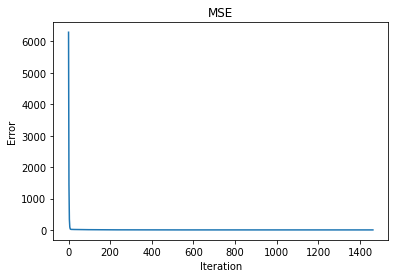

In [29]:
#Model Errors for each iteration
plt.plot(errors)
plt.title("MSE")
plt.xlabel("Iteration")
plt.ylabel("Error")

Clearly, the average error is dropping significantly during the first iterations. The following iteratios squeeze out some extra performance gains.

A residual is simply the error between the prediction and the ground truth value (the coffee rating). We compute the $i^{th}$ residual for the $i^{th}$ sample as 

$$res_i = y - \hat{y},$$

where $\hat{y}$ is the predicted value from the model. 

The residual plot shown above is a scatter plot of the residuals versus the predicted values. One of the assumptions of linear regression is to have no patterns in the residuals. In other words, our model should have consistent predictions.

Text(0.5, 1.0, 'Residuals vs fitted values plot for homoscedasticity check')

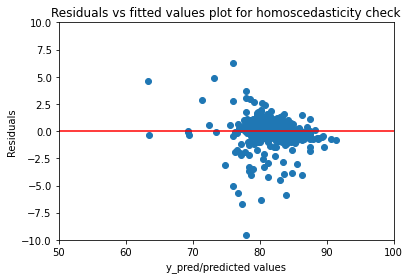

In [30]:
#residual plot
pred = predict(beta_vector, X_train)
residuals = y_train - pred
plt.scatter(pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(50,100)
plt.plot([0,100],[0,0],color='red')
plt.title('Residuals vs fitted values plot for homoscedasticity check')

Indeed, there are is a lack of pattern in the residual plot, and we satisfy one of the assumptions of regression modeling. We can also analyze the QQ-plot of the residuals, which tells us if the residuals are roughly normally distributed, another requirement of regression modeling.

Text(0.5, 1.0, 'QQ-plot of Residuals')

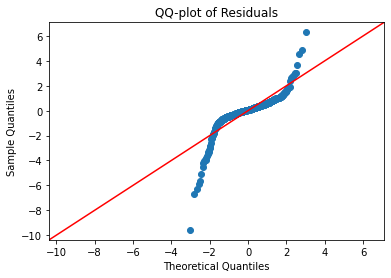

In [31]:
sm.qqplot(residuals, line ='45') 
plt.title("QQ-plot of Residuals")

Indeed, from the plot we see that the residuals closely hug the red line, showing that they are nearly normally distributed.

We may also look at the $R^2$ value of the regression model, which is a quantitative metric as to how well the model is explaining the variation in the data. The $R^2$ value is bettwen zero and one, with a value closer to one meaning the model is explaining most of variation in the data. A value closer to zero shows that the model is not a good fit for the data, as it is explaining little of the variation.

The $R^2$ value is given by
$$R^2 := \frac{\sum^n_{i=1} (y_i - \hat{y}_i)^2}{\sum^{n}_{i=1}(y_i - \bar{y})^2},$$

where $\bar{y}$ is the mean of the target values.

In [32]:
#getting R^2 value
def r_squared(predictions, y):
    s_one = 0
    for i in range(len(y)):
        s_one += (y[i] - predictions[i])**2
    s_two = 0
    ybar = np.mean(y)
    for i in range(len(y)):
        s_two += (y[i]- ybar)**2
    return 1 - s_one/s_two

In [33]:
r_squared(pred, y_train)

0.8489220463837024

In [54]:
print("Average Residual", np.mean(np.square(pred - y_train)))

Average Residual 1.0933943991975246


Our $R^2$ value of **x** is large, so that our model is appearing to explain most of the variation in the data.

Given that the data is scaled, the larger the beta value is, the more impact the corresponding feature has on the model. We may interpret the beta values as follows:

*For every increase of one unit of feature $x_j$, the total_cup points increases (or decreases) by $\beta_j$ much.*

With this interpretation, we can see give a bar plot of the beta values with respect to each predictor attribute to note the the predictor importance.

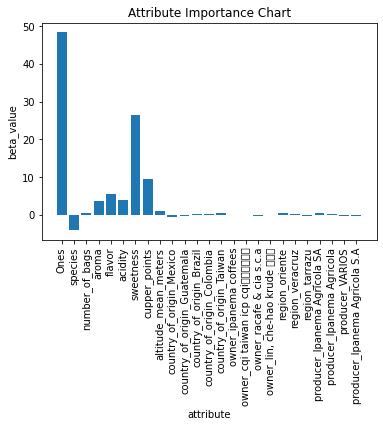

In [34]:
#predictor attribute importance
feature_importance_matrix = pd.DataFrame()
feature_importance_matrix['feature'] = features
feature_importance_matrix['beta'] = beta_vector
plt.bar(feature_importance_matrix['feature'], feature_importance_matrix['beta'])
plt.xlabel("attribute")
plt.ylabel("beta_value")
plt.title("Attribute Importance Chart")
plt.xticks(rotation=90)
plt.show()

In [50]:
feature_importance_matrix

,feature,beta
0,Ones,48.316695
1,species,-4.080198
2,number_of_bags,0.541982
3,aroma,3.752804
4,flavor,5.564904
5,acidity,4.035927
6,sweetness,26.315965
7,cupper_points,9.405062
8,altitude_mean_meters,1.053524
9,country_of_origin_Mexico,-0.515494


It appears that sweetness contributes the most to our model, while other attributes like the producer contribute less. To further quanitfy this analysis. We now produce p-values and confidence intervals for our beta coefficients.

The $p$-value of a beta coefficient gives us the probability of the coefficient being zero. So low values of $p$ will give us the conclusion that our predictor attribute is significant. The $p$-value for a particular beta coeffcient is read off of the $t$-table, where $t$ is given by

$$t_i: = \frac{\beta_i}{sse_{\beta_i}} \:\:\:\:\: 1 \le i \le p,$$

where

$$se_{\beta_i} := \frac{s}{\sqrt{\sum^{n}_{k=1}(x^{(i)}_k - \bar{x}^{(i)})^2}}$$

is the standard error, for

$$s:=\sqrt{\frac{\sum^n_{i=1}(\hat{y}^{(i)} - y^{(i)})^2}{n-p}}.$$

Below is the code for the $p$-values of the beta coefficients.

In [35]:
#p-values
coefficient_dictionary = feature_importance_matrix.set_index('feature')['beta'].to_dict()

def s(target, predictions, coefficients):
    df = len(target) - len(coefficients)
    ss_reds = 0
    for i in range(len(target)):
        ss_reds += ((predictions[i] - target[i])**2)
    return np.sqrt(ss_reds/df)

def se(s_val, attribute, dataframe):
    x = dataframe[attribute]
    x_mean = np.mean(x)
    ss_x_mean = 0
    for i in range(len(x)):
        ss_x_mean += ((x[i]-x_mean)**2)
    return s_val/np.sqrt(ss_x_mean)

def t_value(coefficients, attribute, se_beta):
    return coefficients[attribute]/se_beta

def p_val(target, predictions, attribute, dataframe, coefficients):
    s_val = s(target, predictions, coefficients)
    se_val = se(s_val, attribute, dataframe)
    t = t_value(coefficients, attribute, se_val)
    df = len(target) - len(coefficients)
    return (1 - stats.t.cdf(np.abs(t), df)) * 2

In [36]:
p_values = []
df.columns = features
for i in range(len(features)):
    p_values.append(np.round(p_val(y_train, pred, df.columns[i], df, coefficient_dictionary), 5))
    
sig_list = []
for i in range(len(p_values)):
    if(p_values[i] < 0.05):
        sig_list.append(1)
    else:
        sig_list.append(0)
    
p_value_df = pd.DataFrame(columns = ['Attribute', 'p-val', 'Significant'])
p_value_df['Attribute'] = features
p_value_df['p-val'] = p_values
p_value_df['Significant'] = sig_list
p_value_df

,Attribute,p-val,Significant
0,Ones,1.00000,0
1,species,0.00000,1
2,number_of_bags,0.04807,1
3,aroma,0.00000,1
4,flavor,0.00000,1
5,acidity,0.00000,1
6,sweetness,0.00000,1
7,cupper_points,0.00000,1
8,altitude_mean_meters,0.00036,1
9,country_of_origin_Mexico,0.00000,1


In [37]:
#getting significant attributes
significant_attributes = p_value_df[p_value_df['Significant'] ==1]["Attribute"]
print(significant_attributes)

1                          species
2                   number_of_bags
3                            aroma
4                           flavor
5                          acidity
6                        sweetness
7                    cupper_points
8             altitude_mean_meters
9         country_of_origin_Mexico
10     country_of_origin_Guatemala
12      country_of_origin_Colombia
13        country_of_origin_Taiwan
18                  region_oriente
21    producer_Ipanema Agrícola SA
Name: Attribute, dtype: object


The above list gives all attributes in which their corresponding $p$-value for the beta coefficient is significant, i.e., $p < 0.05$. We can also generate confidence intervals around our beta coefficient values to see if zero falls in the interval, meaning the corresponding attribute will not be significant. The confidence interval (CI) is given by

$$CI_i = (\beta_i - t_{\alpha/2, df}\cdot se_{\beta_i}, \beta_i + t_{\alpha/2, df}\cdot se_{\beta_i}).$$

In this setting, we will set $\alpha := 0.05$. Below is the code to generate confidence intervals.

In [38]:
def confidence_interval(target, predictions, coefficients, attribute, dataframe):
    df = len(target) - len(coefficients)
    critical_val = stats.t.ppf(1 - (0.05/2), df)
    s_val = s(target, predictions, coefficients)
    se_val = se(s_val, attribute, dataframe)
    beta_val = coefficients[attribute]
    return (np.round(beta_val - (critical_val*se_val), 5), np.round(beta_val + (critical_val*se_val), 5))

In [51]:
c_ints = []
for i in range(len(features)):
    c_ints.append(confidence_interval(y_train, pred, coefficient_dictionary, features[i], df))
    
c_int_df = pd.DataFrame(columns = ['Attribute', "Conf_Interval"])
c_int_df['Attribute'] = features
c_int_df['Conf_Interval'] = c_ints
c_int_df = c_int_df.iloc[1:]
print("Confidence Inervals")
c_int_df

Confidence Inervals


,Attribute,Conf_Interval
1,species,"(-4.50265, -3.65774)"
2,number_of_bags,"(0.00462, 1.07934)"
3,aroma,"(3.22977, 4.27584)"
4,flavor,"(5.04662, 6.08319)"
5,acidity,"(3.4613, 4.61055)"
6,sweetness,"(25.2517, 27.38023)"
7,cupper_points,"(8.6445, 10.16562)"
8,altitude_mean_meters,"(0.47666, 1.63039)"
9,country_of_origin_Mexico,"(-0.67229, -0.3587)"
10,country_of_origin_Guatemala,"(-0.41066, -0.04215)"
